In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "/content/drive/MyDrive/data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2

WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10

In [3]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]
                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={SELECTED_POSITIONS}"
    )
    return dfs

In [4]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)


def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]


def build_dataset_cnn(dfs, feature_cols):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            window_data = w[feature_cols].values
            X.append(window_data)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return (
        np.array(X),
        np.array(y),
        np.array(groups),
        np.array(positions)
    )

In [5]:
class ActivityDataset(Dataset):
    def __init__(self, X, y, scaler=None):
        if scaler is not None:
            orig_shape = X.shape
            X_flat = X.reshape(-1, X.shape[-1])
            X_flat = scaler.transform(X_flat)
            X = X_flat.reshape(orig_shape)
        self.X = torch.FloatTensor(X).transpose(1, 2)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
class CNN1D(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(num_features, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.3)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return avg_loss, accuracy, all_preds, all_labels

In [9]:
def evaluate_cnn(X, y, groups, title, num_features):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    num_classes = len(le.classes_)

    outer_cv = GroupKFold(n_splits=5)

    y_true_all, y_pred_all = [], []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_encoded, groups), 1):
        print(f"\n{'='*50}")
        print(f"Fold {fold}/5")
        print(f"{'='*50}")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        scaler = StandardScaler()
        X_train_flat = X_train.reshape(-1, X_train.shape[-1])
        scaler.fit(X_train_flat)

        train_dataset = ActivityDataset(X_train, y_train, scaler)
        test_dataset = ActivityDataset(X_test, y_test, scaler)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model = CNN1D(num_features, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=5
        )

        best_val_acc = 0
        patience_counter = 0
        best_model_state = None

        for epoch in range(EPOCHS):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = evaluate_epoch(model, test_loader, criterion, device)

            scheduler.step(val_loss)

            if (epoch + 1) % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch+1}/{EPOCHS} - "
                      f"Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, "
                      f"Val Acc: {val_acc:.4f}, "
                      f"LR: {current_lr:.6f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_model_state = model.state_dict().copy()


        if best_model_state:
            model.load_state_dict(best_model_state)

        _, _, preds, labels = evaluate_epoch(model, test_loader, criterion, device)

        y_true_all.extend(labels)
        y_pred_all.extend(preds)

        print(f"Fold {fold} Best Val Accuracy: {best_val_acc:.4f}")

    y_true_labels = le.inverse_transform(y_true_all)
    y_pred_labels = le.inverse_transform(y_pred_all)

    print(f"\n{'='*50}\n=== {title} ===\n{'='*50}")
    print(classification_report(y_true_labels, y_pred_labels, digits=4))

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=SELECTED_ACTIVITIES)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=SELECTED_ACTIVITIES,
                yticklabels=SELECTED_ACTIVITIES, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_true_labels, y_pred_labels, average="macro"),
        "recall": recall_score(y_true_labels, y_pred_labels, average="macro"),
        "f1": f1_score(y_true_labels, y_pred_labels, average="macro")
    }

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']
Raw data shape: (5025, 100, 6)
Using device: cuda

Fold 1/5
Epoch 10/50 - Train Loss: 0.0564, Val Loss: 0.2375, Val Acc: 0.9085, LR: 0.001000
Epoch 20/50 - Train Loss: 0.0372, Val Loss: 0.0991, Val Acc: 0.9592, LR: 0.001000
Epoch 30/50 - Train Loss: 0.0119, Val Loss: 0.1848, Val Acc: 0.9383, LR: 0.000100
Epoch 40/50 - Train Loss: 0.0105, Val Loss: 0.1815, Val Acc: 0.9413, LR: 0.000001
Epoch 50/50 - Train Loss: 0.0109, Val Loss: 0.2108, Val Acc: 0.9413, LR: 0.000000
Fold 1 Best Val Accuracy: 0.9592

Fold 2/5
Epoch 10/50 - Train Loss: 0.0824, Val Loss: 0.0790, Val Acc: 0.9721, LR: 0.001000
Epoch 20/50 - Train Loss: 0.0540, Val Loss: 0.0582, Val Acc: 0.9751, LR: 0.001000
Epoch 30/50 - Train Loss: 0.0197, Val Loss: 0.0419, Val Acc: 0.9851, LR: 0.000100
Epoch 40/50 - Train Loss: 0.0107, Val Loss: 0.0416, Val Acc: 0.9851, LR: 0.000010
Epoch 50

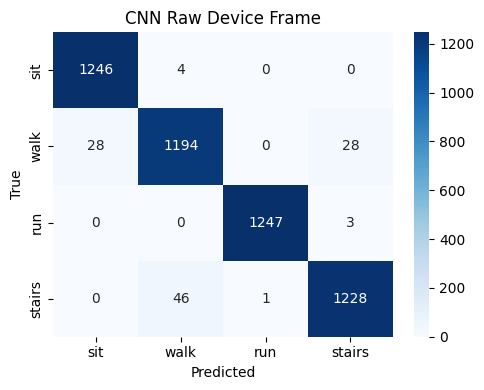

GFT data shape: (5025, 100, 6)
Using device: cuda

Fold 1/5
Epoch 10/50 - Train Loss: 0.1442, Val Loss: 0.2095, Val Acc: 0.9184, LR: 0.001000
Epoch 20/50 - Train Loss: 0.0830, Val Loss: 0.1688, Val Acc: 0.9393, LR: 0.001000
Epoch 30/50 - Train Loss: 0.0491, Val Loss: 0.1317, Val Acc: 0.9612, LR: 0.000100
Epoch 40/50 - Train Loss: 0.0326, Val Loss: 0.1299, Val Acc: 0.9562, LR: 0.000001
Epoch 50/50 - Train Loss: 0.0430, Val Loss: 0.1403, Val Acc: 0.9552, LR: 0.000000
Fold 1 Best Val Accuracy: 0.9612

Fold 2/5
Epoch 10/50 - Train Loss: 0.1557, Val Loss: 0.2220, Val Acc: 0.9254, LR: 0.001000
Epoch 20/50 - Train Loss: 0.0893, Val Loss: 0.2843, Val Acc: 0.9184, LR: 0.001000
Epoch 30/50 - Train Loss: 0.0440, Val Loss: 0.3334, Val Acc: 0.9114, LR: 0.000100
Epoch 40/50 - Train Loss: 0.0386, Val Loss: 0.3702, Val Acc: 0.9134, LR: 0.000001
Epoch 50/50 - Train Loss: 0.0450, Val Loss: 0.3522, Val Acc: 0.9144, LR: 0.000000
Fold 2 Best Val Accuracy: 0.9303

Fold 3/5
Epoch 10/50 - Train Loss: 0.1553, 

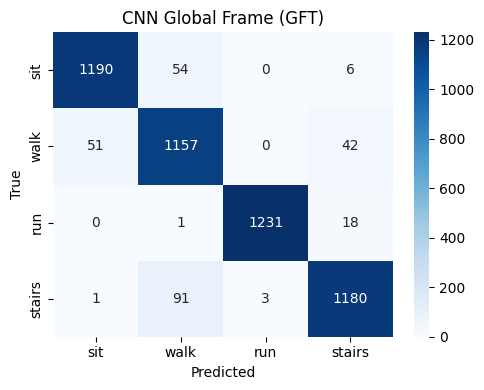

Summary
Raw Device Frame: {'precision': 0.9781012633710149, 'recall': 0.9781843137254903, 'f1': 0.9781092631024402}
Global Frame (GFT): {'precision': 0.9476705767362754, 'recall': 0.9469725490196079, 'f1': 0.9471801490772035}


In [10]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw, _ = build_dataset_cnn(recordings, RAW_FEATURES)
    print(f"Raw data shape: {X_raw.shape}")

    raw_metrics = evaluate_cnn(
        X_raw, y_raw, g_raw,
        "CNN Raw Device Frame",
        num_features=len(RAW_FEATURES)
    )

    X_gft, y_gft, g_gft, _ = build_dataset_cnn(recordings, GFT_FEATURES)
    print(f"GFT data shape: {X_gft.shape}")

    gft_metrics = evaluate_cnn(
        X_gft, y_gft, g_gft,
        "CNN Global Frame (GFT)",
        num_features=len(GFT_FEATURES)
    )

    print("Summary")
    print("Raw Device Frame:", raw_metrics)
    print("Global Frame (GFT):", gft_metrics)